In [16]:
# import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

import os
os.environ["KERAS_BACKEND"] = "tensorflow"


# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow import math as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

import keras

print ('modules loaded')

modules loaded


# **Create needed functions**

### **Function to create dataframe from dataset**

In [17]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

### **Function to create image generators and augmentation**

In [18]:
def create_gens(df, aug_dict):
    img_size = (128, 128)
    batch_size = 40


    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

### **Function that have Unet structure**

In [19]:
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2

REGULARIZATION_WEIGHT = 0.001
REGULARIZATION_FUNCTION = None ## L2(REGULARIZATION_WEIGHT)


def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)
    drop5 = Dropout(0.5)(bn5)

    # UpConvolution / Decoder Leg
    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(drop5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    # Adding Multiply layer
    mul6 = Multiply()([bn6, bn4])

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(mul6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    # Adding Add layer
    add7 = Add()([bn7, bn3])

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(add7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    # Adding Multiply layer
    mul8 = Multiply()([bn8, bn2])

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(mul8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), activity_regularizer=REGULARIZATION_FUNCTION, padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    # Adding Add layer
    add9 = Add()([bn9, bn1])

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid", activity_regularizer=None)(add9)

    return Model(inputs=[inputs], outputs=[conv10])


### **Functions for coefficients and loss**

In [20]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = tf.reshape(y_true, [-1])
    y_pred_flatten = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    union = tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = tf.reduce_sum(y_true * y_pred)
    sum = tf.reduce_sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

### **Function to show images sample**

In [21]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

### **Function to display training history**

In [22]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(iou_coef)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(dice_coef)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

# **Model Structure**

### **Start reading data**

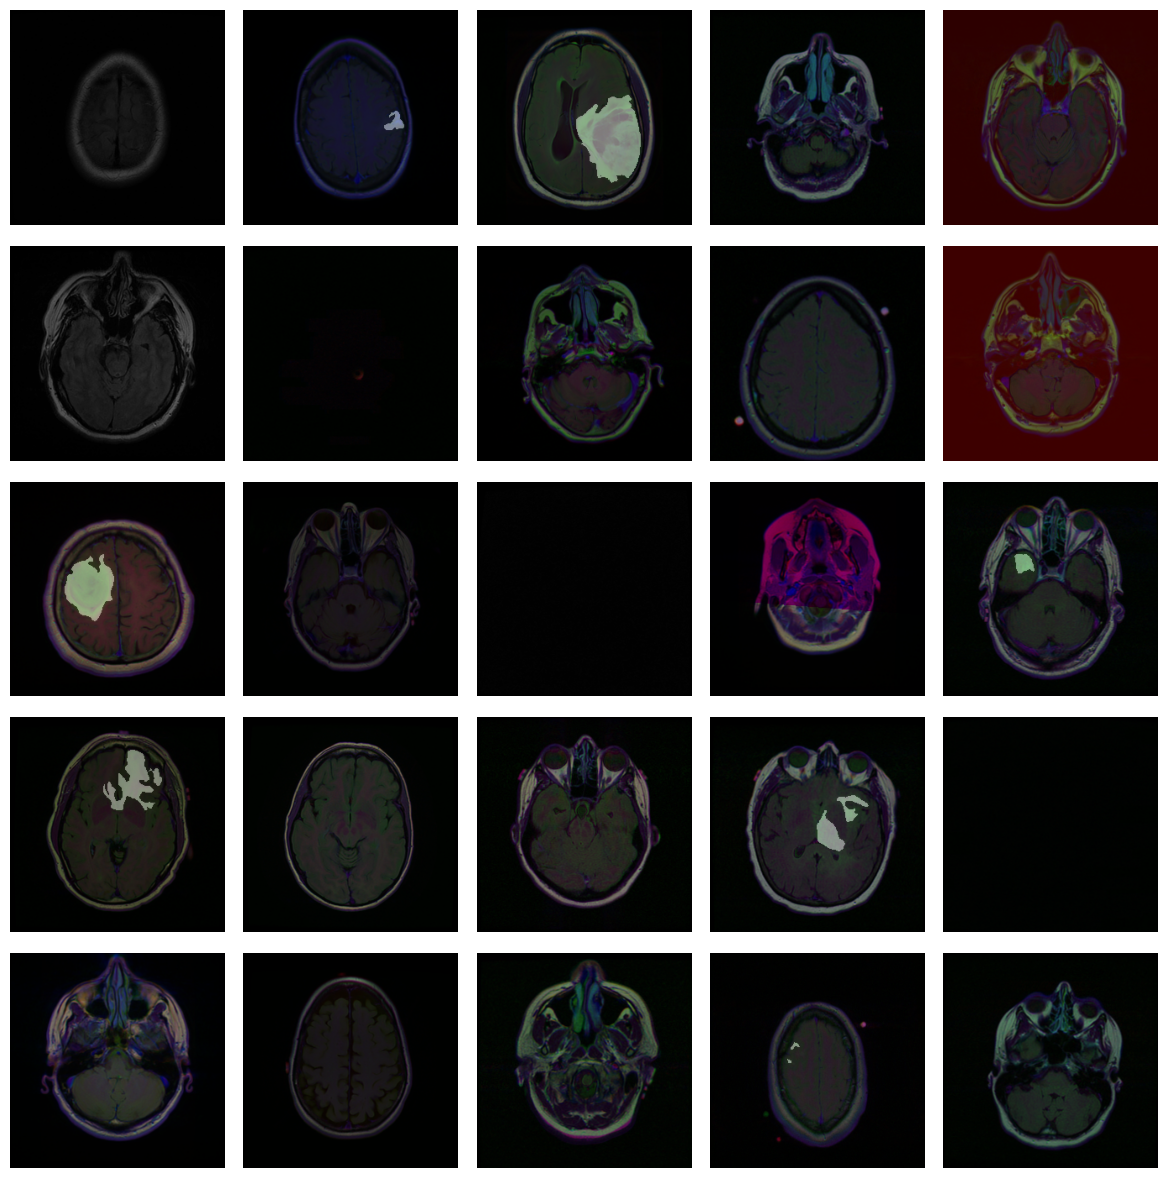

In [23]:
data_dir = './lgg-mri-segmentation/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)


tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

### **Unet Model**

In [24]:
model = unet()
model.compile(Adamax(learning_rate= 0.02), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])
# model.compile(optimizer=Adam(learning_rate=0.002), loss=dice_loss, metrics=['accuracy', iou_coef, dice_coef])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 128, 128,  │          0 │ conv2d_19[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 32, 32,    │          0 │ conv2d_23[0][0]   │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ activation_22[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_24[0][0] 

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [25]:
print(len(train_df))

3143


In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### **Model training**

In [27]:
epochs = 100
batch_size = 128
callbacks = [ModelCheckpoint('unet.keras', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_df) // batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data = valid_gen,
                    validation_steps=len(valid_df) // batch_size)

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8526 - dice_coef: 0.1490 - iou_coef: 0.0868 - loss: -0.1490Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02419, saving model to unet.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 419ms/step - accuracy: 0.8556 - dice_coef: 0.1517 - iou_coef: 0.0886 - loss: -0.1517 - val_accuracy: 0.2315 - val_dice_coef: 0.0242 - val_iou_coef: 0.0123 - val_loss: -0.0242
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9851 - dice_coef: 0.3344 - iou_coef: 0.2107 - loss: -0.3344
Epoch 2: val_loss improved from -0.02419 to -0.16185, saving model to unet.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - accuracy: 0.9851 - dice_coef: 0.3359 - iou_coef: 0.2118 - loss: -0.3359 - val_accuracy: 0.9374 - val_dice_coef: 0.1618 - val_iou_coef: 0.0906 - val_loss: -0.1618
Epoch 3/100
24/24 ━━━━━━━━━━

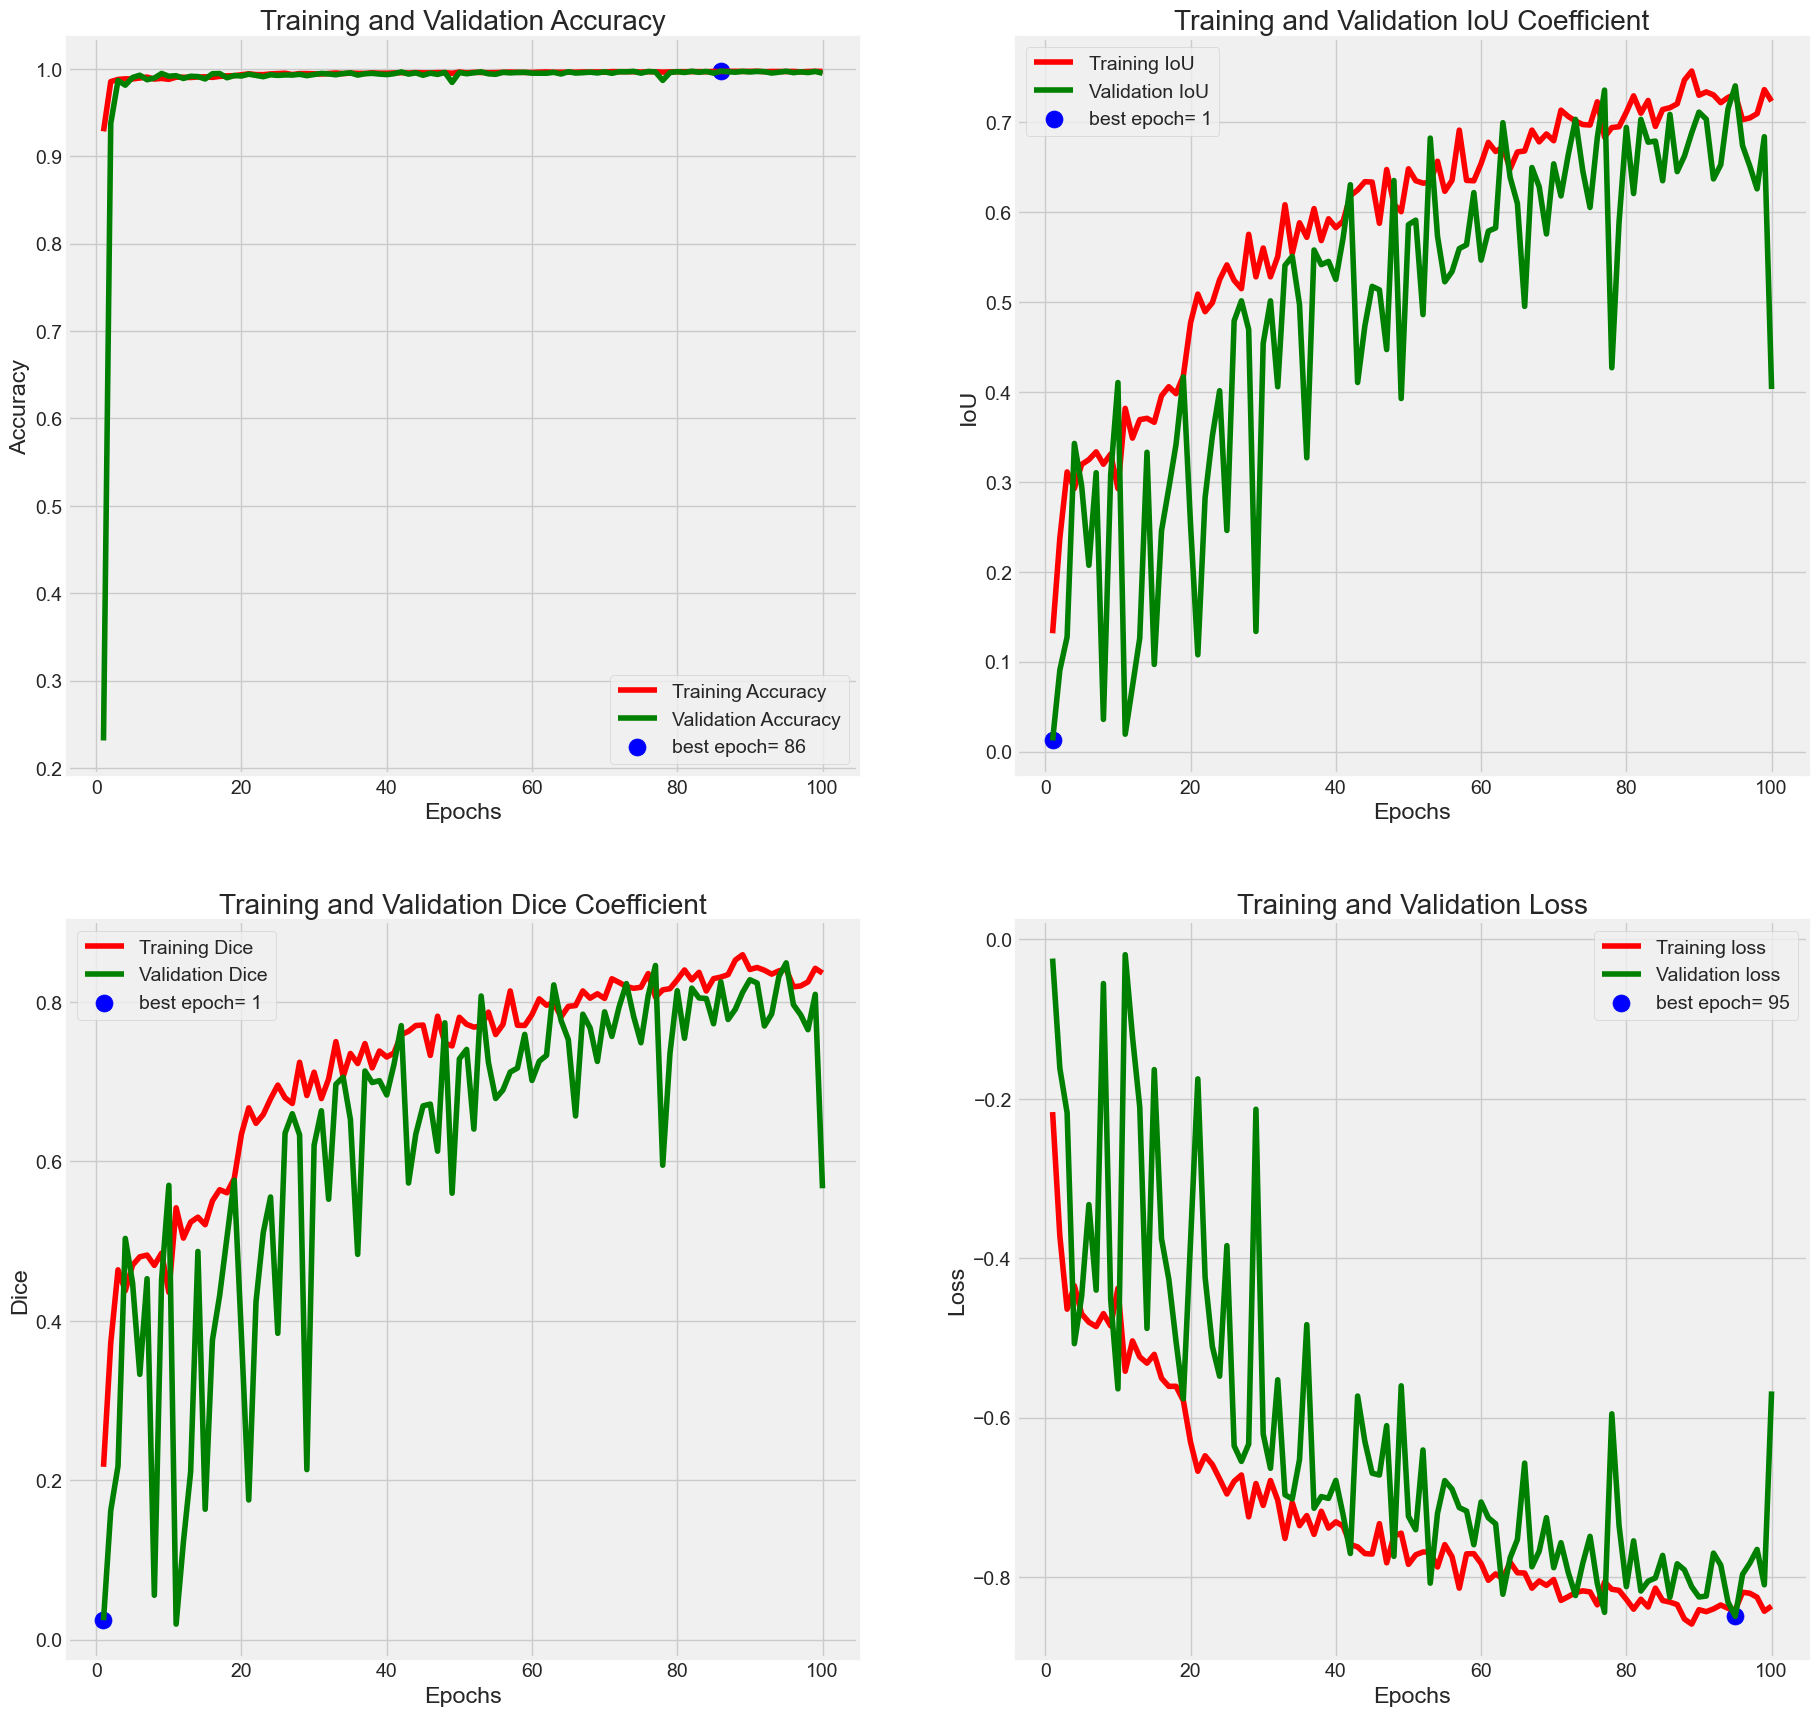

In [28]:
plot_training(history)

### **Model Evaluation**

In [ ]:
model.load_weights('unet.keras')

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9924 - dice_coef: 0.4205 - iou_coef: 0.2783 - loss: -0.4202
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.9931 - dice_coef: 0.4640 - iou_coef: 0.3145 - loss: -0.4634
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.9925 - dice_coef: 0.4459 - iou_coef: 0.2994 - loss: -0.4469
Train Loss:  -0.4310733675956726
Train Accuracy:  0.9923582077026367
Train IoU:  0.28665000200271606
Train Dice:  0.4305588901042938
--------------------
Valid Loss:  -0.46599531173706055
Valid Accuracy:  0.9930074214935303
Valid IoU:  0.3164062798023224
Valid Dice:  0.4663321077823639
--------------------
Test Loss:  -0.44177159667015076
Test Accuracy:  0.9924158453941345
Test IoU:  0.2944493591785431
Test Dice:  0.4404737651348114


# **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


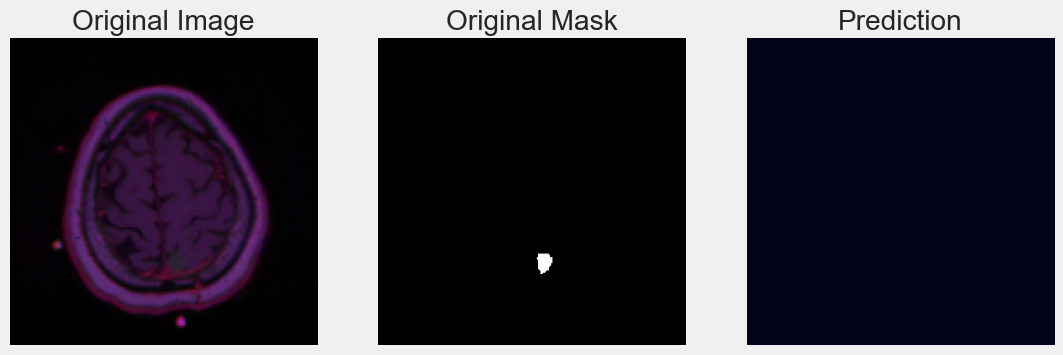

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


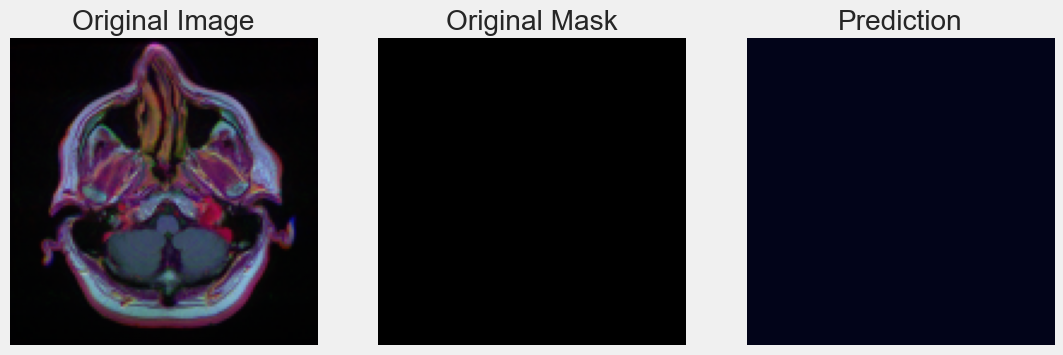

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


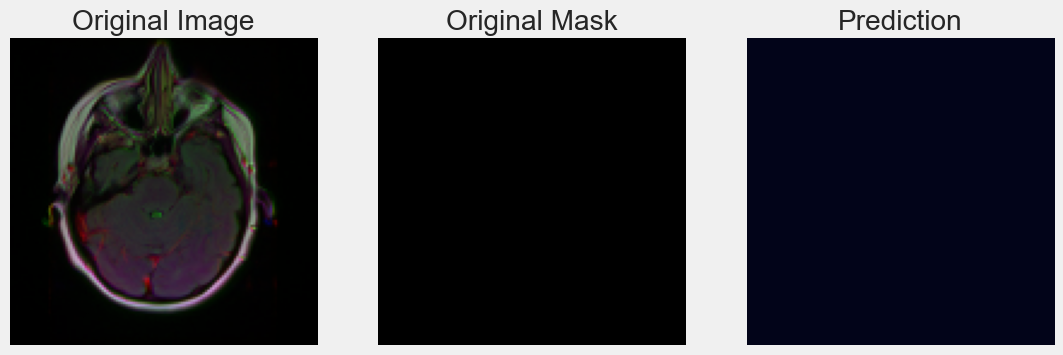

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


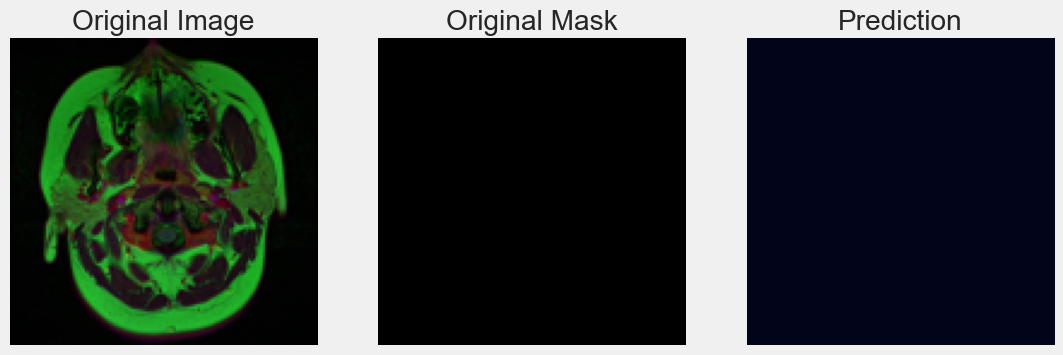

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


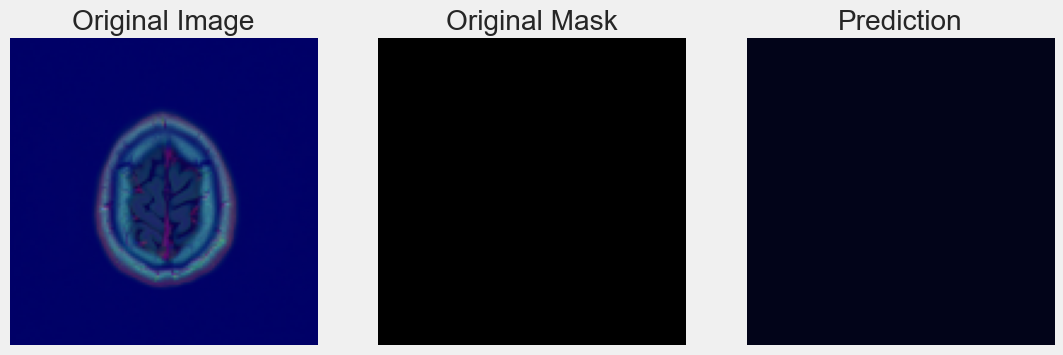

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


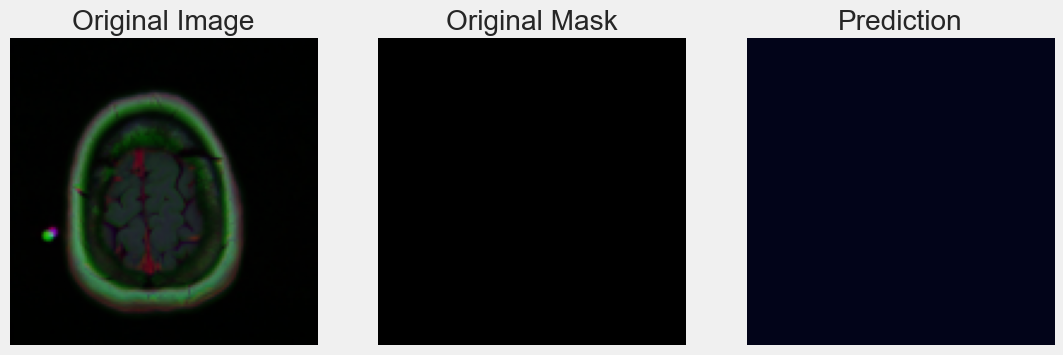

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


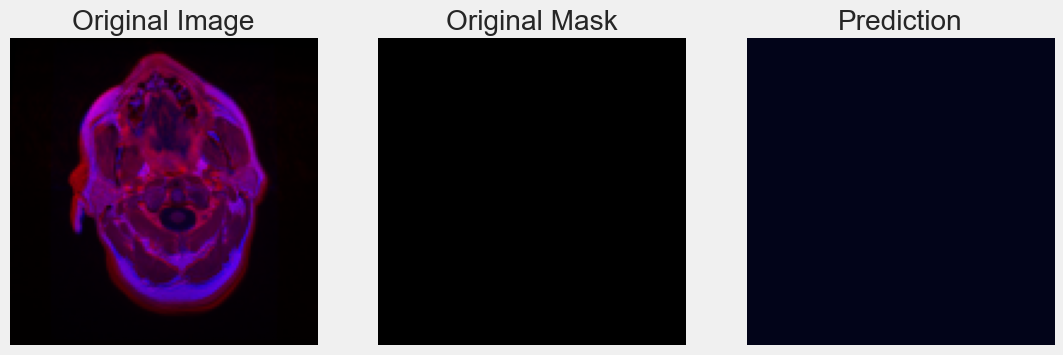

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


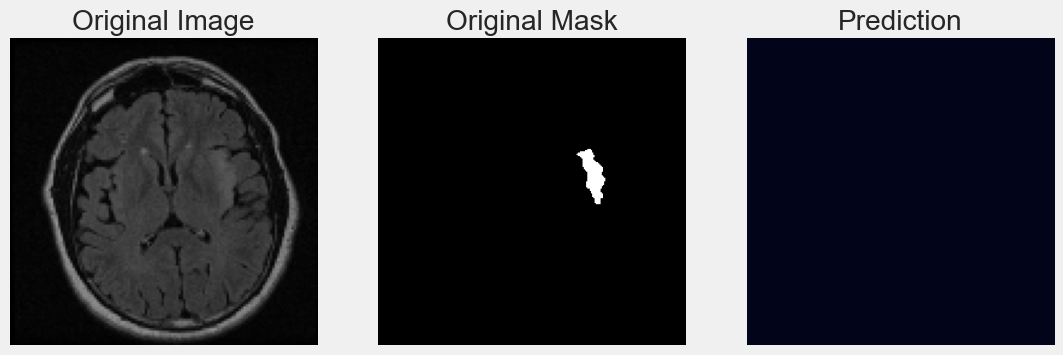

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


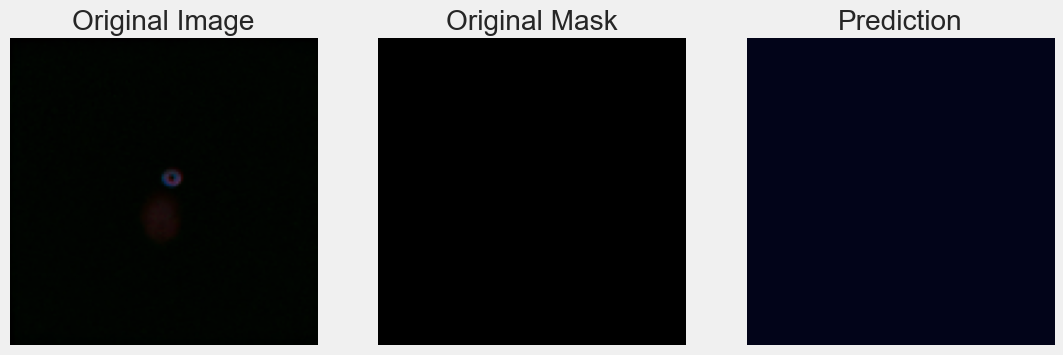

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


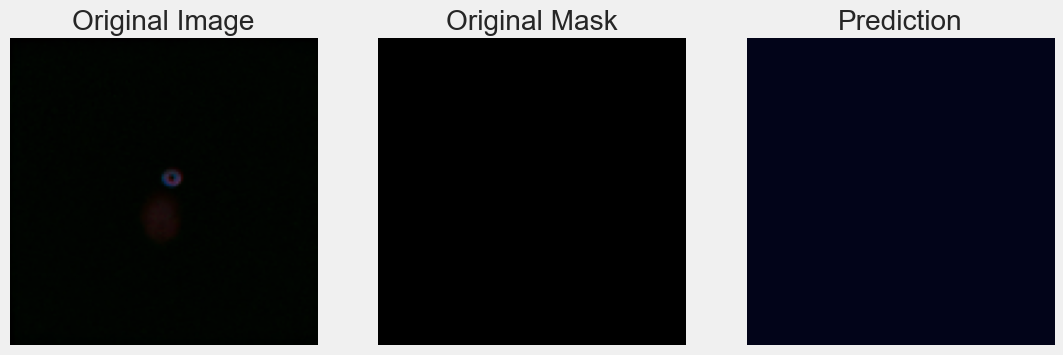

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


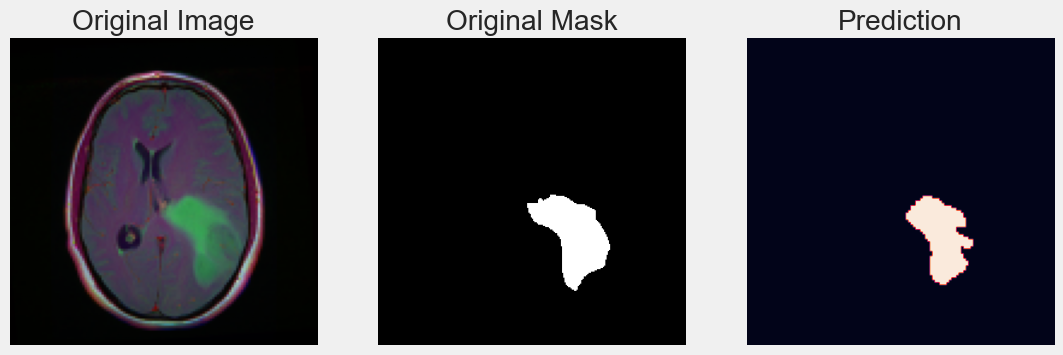

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


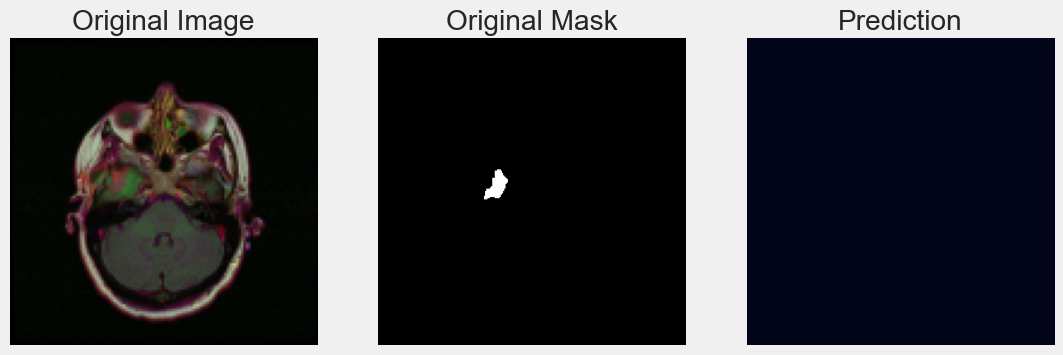

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


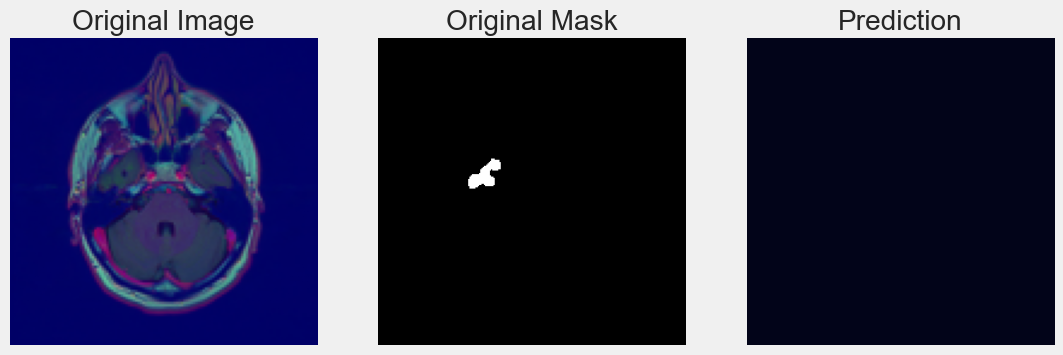

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


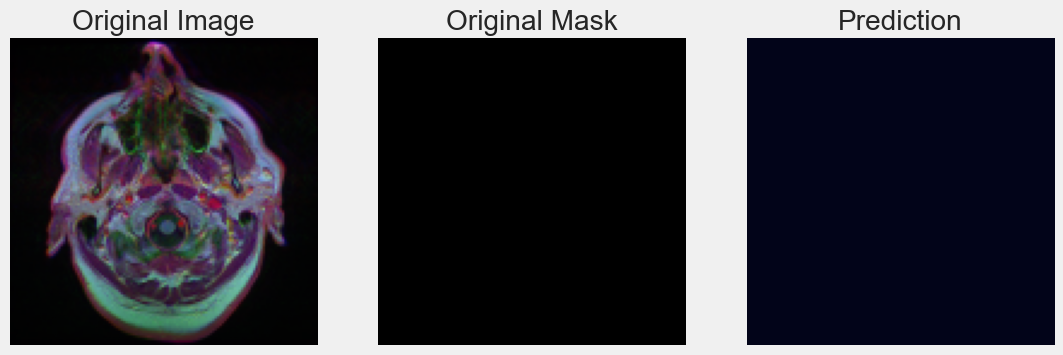

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


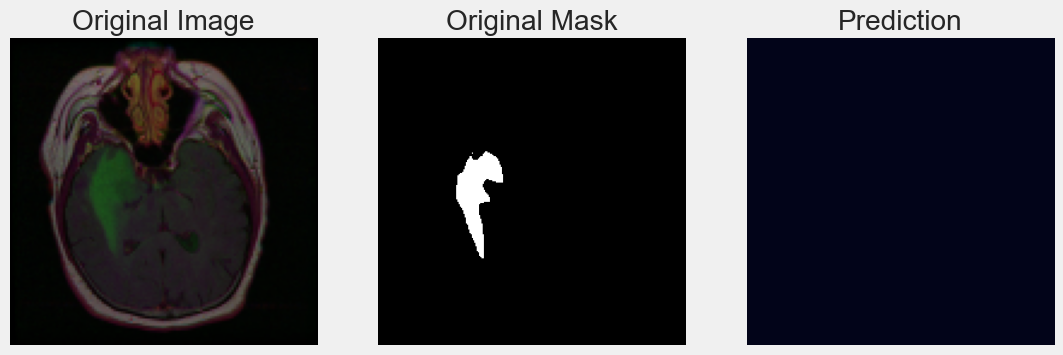

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


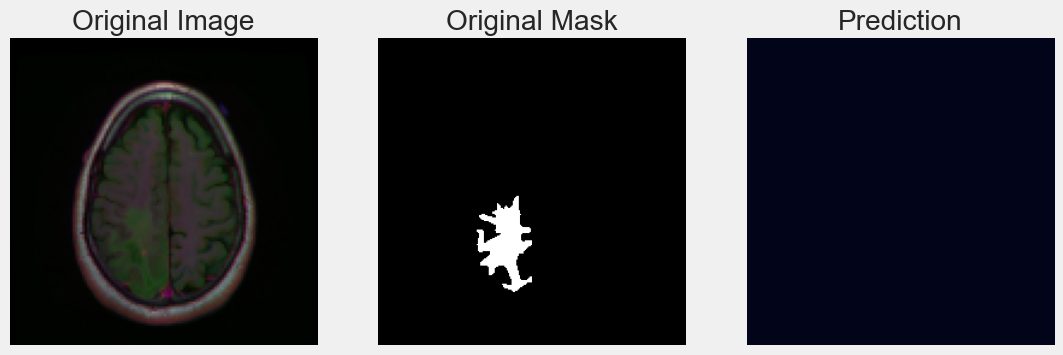

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


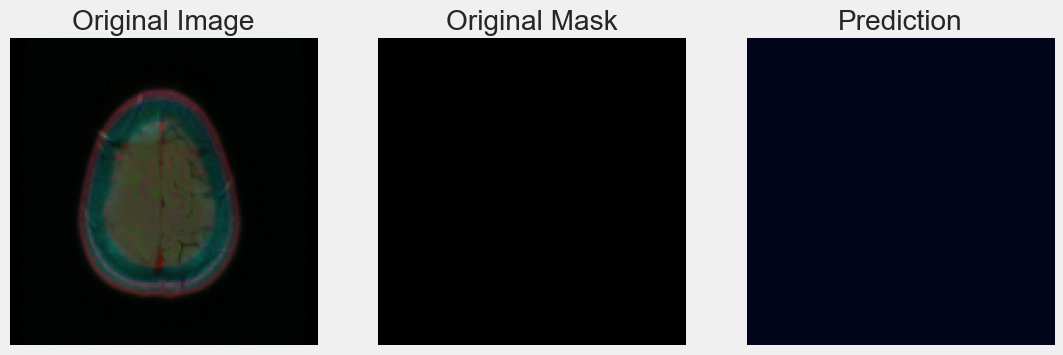

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


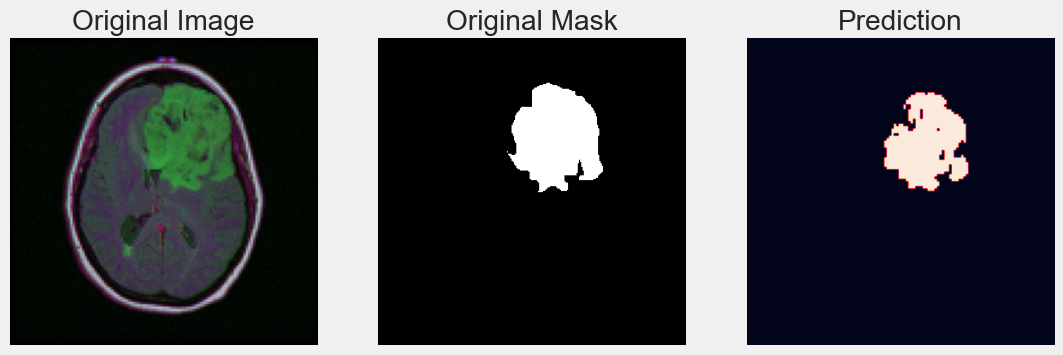

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


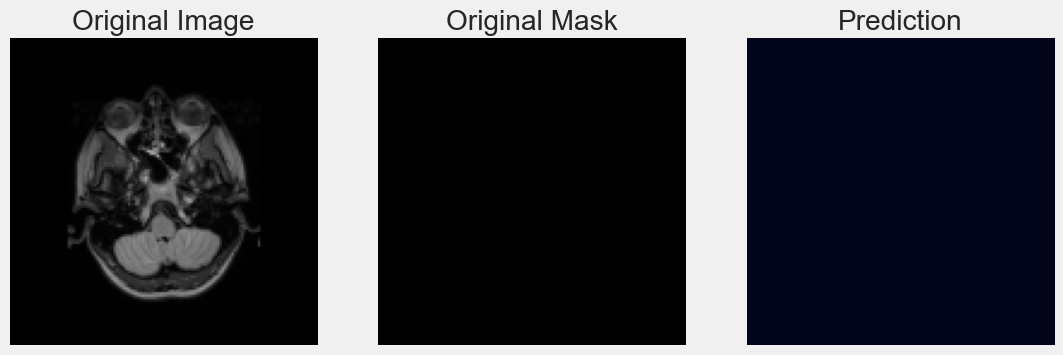

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


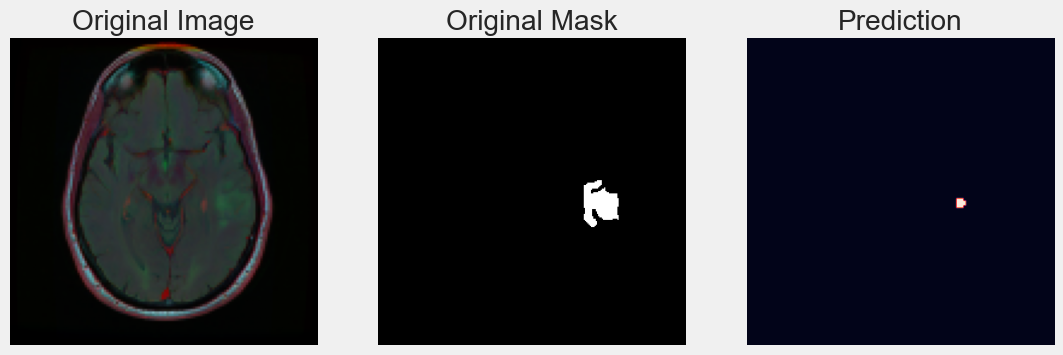

In [30]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (128, 128))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()